# PaMoDaCo: Contextualizing a downcore record in model-space

---

## Overview
One of the critical elements in paleoclimate today is pulling together multiple datasets, either in the spirit of data-model comparison or multiple datasets to build a fuller context. 

In the coarse iTRACE simulations, $\Delta^{14}$C is split into abiotic and biotic components. Here we look at abiotic $\Delta^{14}$C which is like biotic $\Delta^{14}$C except it doesn't account for isotope fractionation from biological processes or air-sea gas exchange. 

While 3 degrees will not resolve the role of eddies, nor will any of the current paleoceanographic proxies, and they offer a pleasingly tractable data product with coverage not susceptible to dissolution (take that, glacial deep North Pacific!).  

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
from pathlib import Path

# import folium 
# import pyperclip as c

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from matplotlib import cm


import pandas as pd
import re
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
 

## Scientific Question
It is widely hypothesized that CO$_{2}$ accumulated in the deep ocean during the last glacial period, and that its release at the onset of the deglaciation was critical to the warming that paved the way to the Holocene. At the surface, water exchanges CO$_{2}$ with the atmosphere, however, once at depth, the only source of radiocarbon is organic matter exported from the surface ocean. In a more stratified glacial ocean, organic matter exported from the surface ocean would have regenerated at depth, where it would have been sequestered, gradually losing radiocarbon through decay. 
<br><br>
The somewhat iconic (if you are inclined that way) two step increase in atmospheric CO$_{2}$ during the deglaciation is consistent with such a hypothesis, and is bolstered by a roughly coincident, two-phase decrease in atmospheric radiocarbon not readily explained by changes in production. The atmospheric record is broadly believed to reflect changes in ocean circulation that gave rise to fluxes of CO$_{2}$ from the deep ocean reservoir to the atmosphere. 
<br><br>
However, balancing both the CO$_{2}$ and radiocarbon budget has proven challenging for a number of reasons, not the least of which is that the sediments that would be most telling were were largely dissolved by the very carbonic acid they might have documented. Evidence tampering, indeed!
<br><br>
As an alternative, let's dip into this question by looking into results from the C-iTrace model runs and some data collected from intermediate depth cores off the coast of Baja California by [Marchitto et al, 2007](https://doi.org/10.25921/6nm6-2c24).  Intermediate depth cores cannot directly tell the story, but if there was a CO$_{2}$-rich, radiocarbon-poor watermass that upwelled at the start of the deglaciation, driving the atmospheric signal, it would have had to pass through intermediate depths somewhere, and perhaps there are footprints to be found. 


# Load Data
The radiocarbon data from the C-iTrace project runs around 6Gb. While this is not impassable, we will make use of the fact that Xarray allows a dataset to be opened and indexed without being loaded into memory. As such, this entire notebook will turn on a series of queries that return slices of the data in order to hold some resources in reserve for delightful things like visualizations. 

In [3]:
PF_data_dir = Path('/Users/jlanders/PycharmProjects/PangeoForge_recipes/C-iTRACE/data')

In [4]:
file_name = 'ctrace.decadal.ABIO_D14Cocn.nc'
c14_ocn_nc = xr.open_dataset(PF_data_dir/'netcdf4'/file_name, use_cftime=True)#, engine='netcdf4', decode_coords=True)#.load()#, decode_coords=True)

file_name = 'ctrace.decadal.ABIO_D14Catm.nc'
c14_atm_nc = xr.open_dataset(PF_data_dir/'netcdf4'/file_name, use_cftime=True)#, engine='netcdf4', decode_coords=True)#.load()#, decode_coords=True)
# ds_Nd143

In [5]:
iso_ds = xr.combine_by_coords([c14_ocn_nc['ABIO_D14Cocn'].astype(np.float64), 
                               c14_atm_nc['ABIO_D14Catm'].astype(np.float64)])

In [6]:
def convert_z_to_meters(ds):
    cm_to_m = 1/100
    z_t = ds.z_t.data
    ds['z_t_m'] = ("z_t", z_t*cm_to_m)
    ds = ds.swap_dims({'z_t':'z_t_m'})
    return ds

In [7]:
# convert depth from cm to m
iso_ds =convert_z_to_meters(iso_ds)
iso_ds

<xarray.Dataset>
Dimensions:       (time: 2200, nlat: 116, nlon: 100, z_t_m: 60)
Coordinates:
  * time          (time) float64 -22.0 -21.99 -21.98 ... -0.03 -0.02 -0.01
    TLAT          (nlat, nlon) float64 ...
    TLONG         (nlat, nlon) float64 ...
    z_t           (z_t_m) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_m         (z_t_m) float32 5.0 15.0 25.0 ... 5.125e+03 5.375e+03
Dimensions without coordinates: nlat, nlon
Data variables:
    ABIO_D14Catm  (time, nlat, nlon) float64 9.969e+36 9.969e+36 ... 9.969e+36
    ABIO_D14Cocn  (time, z_t_m, nlat, nlon) float64 nan nan nan ... nan nan nan

# Explore
As a first step, let's pull together a few plots that will allow us to verify that we have a grasp on space and time in this dataset (and/or that the model did as well!) by plotting two sections (one from the Pacific, one from the Atlantic) along lines of constant longitude from the recent (ish--it's all relative...this would not constitute "recent" as it might pertain to how long ago I purchased the milk in my refrigerator ) past, the mid deglaciation, and the late glacial period. 

> _Tech Tip:_ In order to ensure grids of plots are organized and well labeled, it can be helpful to collect the data in dictionaries. 

In [8]:
glacial_kya = 18
deglacial_kya = 14
hol_kya = 3
time_cats = ['glacial', 'deglacial', 'holocene']
var = 'ABIO_D14Cocn'
tracer_label = "$\Delta^{14}$C ($\perthousand$)"

coords_pac = {'lat': [-85, 75], 'lon': 224.470996, 'depth' :(6000,0)}
coords_atl = {'lat': [75,-85], 'lon': 334, 'depth' :(6000,0)}

def make_meta_d(coords):
    return {'coords': coords, 
            'time_d':{'glacial':{'kya':glacial_kya},
                      'deglacial':{'kya':deglacial_kya},
                      'holocene':{'kya':hol_kya}} }

Pacific = make_meta_d(coords_pac)
Atlantic = make_meta_d(coords_atl)


In [9]:
def between(ds, var, lims):
    _ds = ds.where((ds.coords[var]<max(lims)) & (ds.coords[var]>min(lims)), drop=True)
    return _ds

In [10]:
for key in time_cats:
    data = iso_ds.sel(time=-1*Pacific['time_d'][key]['kya'], method='nearest')
    _sect_ds = between(data, 'TLONG', [Pacific['coords']['lon']-1, Pacific['coords']['lon']+2])
    sect_ds = _sect_ds[var].squeeze()
    Pacific['time_d'][key]['data']= sect_ds.compute()

for key in time_cats:
    data = iso_ds.sel(time=-1*Atlantic['time_d'][key]['kya'], method='nearest')
    _sect_ds = between(data, 'TLONG', [Atlantic['coords']['lon']-1, Atlantic['coords']['lon']+1])
    sect_ds = _sect_ds[var].squeeze()
    Atlantic['time_d'][key]['data']=sect_ds.compute()


> _Tech Tip:_ It can be useful to place grids of plots like the six-section multiplot in the works below, on the same color scale. Adopting a consistent color scale can require a different approach for different plot types, but for the filled contour plots below, it's simply a matter of finding the maximum and minimum values of all data that will be plotted, and calculating "levels". Here we also rounded the values to two decimal placed. 

In [11]:
lim_max = max(tuple(
        [np.nanmax(Pacific['time_d'][key]['data'].data.ravel()) for key in time_cats]+
        [np.nanmax(Atlantic['time_d'][key]['data'].data.ravel()) for key in time_cats]))
lim_min = min(tuple(
        [np.nanmin(Pacific['time_d'][key]['data'].data.ravel()) for key in time_cats]+
        [np.nanmin(Atlantic['time_d'][key]['data'].data.ravel()) for key in time_cats]))

levels = np.around(np.linspace(lim_min, lim_max, 15), decimals=2)


> _Tech Tip:_ Colorbars are wildly informative, but have an annoying habit of ending up positioned awkwardly or causing plots with and without to end up misaligned. The last line of the code cell below constructs a colorbar based on the `contourf` data 

In [12]:
def make_inset_map(ax, lats, lons, central_lon=0,central_lat=0):
    axin = inset_axes(ax, width=.25*5, height=.25*5, loc="lower right", 
                 axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                 axes_kwargs=dict(projection=ccrs.Orthographic(central_latitude=central_lat, 
                                                               central_longitude=central_lon)))
                                                               # central_lon)))

    axin.coastlines(linewidth=.5)
    axin.add_feature(cfeature.LAND, zorder=14)
    axin.plot(lons, lats, transform=ccrs.PlateCarree())
    axin.set_global()


In [13]:
def make_scalar_mappable(lims, cmap, n=None):
    ax_norm = mpl.colors.Normalize(vmin=min(lims), vmax=max(lims), clip=False)
    if type(cmap)==list:
        if n is None:
            ax_cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",["r","b"])
        else:
            ax_cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",["r","b"], N=n)
    else:
        if n is None:
            ax_cmap = plt.get_cmap(cmap)
        else:    
            ax_cmap = plt.get_cmap(cmap, n)
    ax_sm = cm.ScalarMappable(norm=ax_norm, cmap=ax_cmap)
    return ax_sm

In [14]:
n_levels= 60
# make scalar mappable
ax2_sm = make_scalar_mappable([min(levels), max(levels)],'bone' )#[0.0026, .003]
cf2_kwargs = {'cmap':ax2_sm.cmap,'levels':levels, 'norm' : ax2_sm.norm}#mpl.colors.TwoSlopeNorm(vmin=min_val, vcenter=0.0026, vmax=max_val), 'levels':ax2_levels}#SymLogNorm(.00152, linscale=.003)}#, vmin=None, vmax=None, clip=False)ax2_sm.norm}

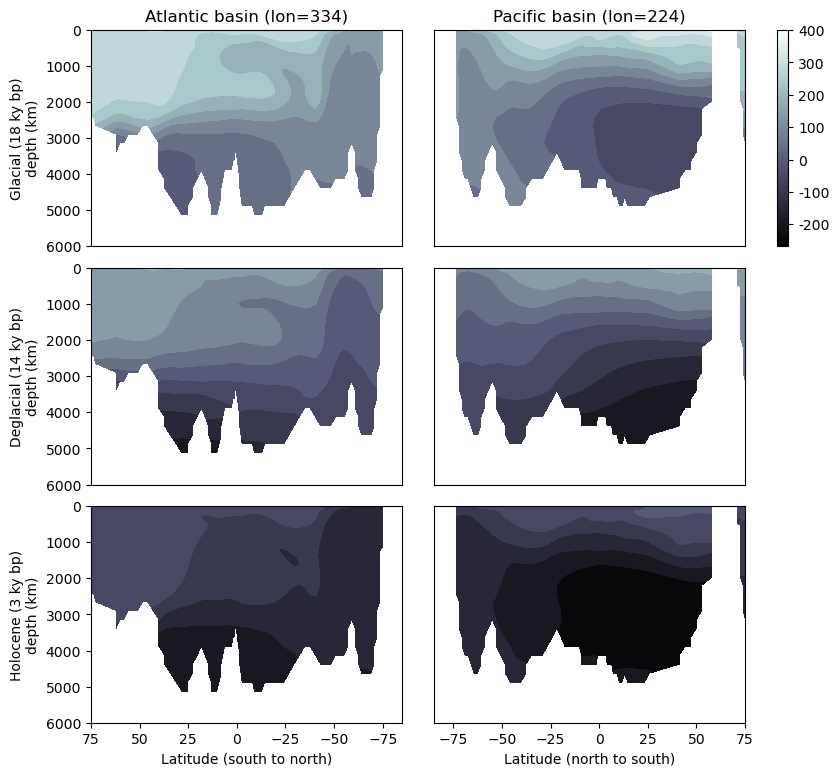

In [15]:
from matplotlib.ticker import FormatStrFormatter
plt.close('all')
fig = plt.figure(figsize=(9,9));

# setup a grid of subplots, cols: Pacific & Atlantic, rows: glacial, degleciation, holocene
gs = gridspec.GridSpec(3, 3, wspace=0.15, hspace=.1, width_ratios=[8,8, .3])

pac_lst = []
atl_lst = []
for ik, key in enumerate(Pacific['time_d'].keys()):
    sect_ds = Pacific['time_d'][key]['data']
    # for scatter, because color var is an array, need to make a mesh version of x and y vars
    lat_mesh, depth_mesh = np.meshgrid(sect_ds.TLAT.mean(dim='nlon'), sect_ds.z_t_m)
    
    ax_pac = fig.add_subplot(gs[ik, 1]);
    ax_pac.contourf(sect_ds.TLAT.mean(dim='nlon'), sect_ds.z_t_m,
                     sect_ds.mean(dim='nlon').squeeze().data,10, origin='upper',
                         levels=levels,
                         cmap=ax2_sm.cmap, 
                        norm=ax2_sm.norm)
    pac_lst.append(ax_pac)
    
    sect_ds = Atlantic['time_d'][key]['data']
    ax_atl = fig.add_subplot(gs[ik, 0]);
    ax_atl.contourf(sect_ds.TLAT.mean(dim='nlon'), sect_ds.z_t_m,
                     sect_ds.mean(dim='nlon').squeeze().data,10, origin='upper',
                         levels=levels,
                         cmap=ax2_sm.cmap, 
                        norm=ax2_sm.norm)
    atl_lst.append(ax_atl)
    
    ax_atl.set(**{'ylim':Atlantic['coords']['depth'], 'xlim':Atlantic['coords']['lat'], 
                    'ylabel':'{} ({} ky bp)\ndepth (km)'.format(str.title(key), 
                                                             Atlantic['time_d'][key]['kya'])})
    ax_pac.set(**{'ylim':Pacific['coords']['depth'], 'xlim':Pacific['coords']['lat']})

    
atl_lst[0].set_title('Atlantic basin (lon={0:.3g})'.format(Atlantic['coords']['lon']))
pac_lst[0].set_title('Pacific basin (lon={0:.3g})'.format(Pacific['coords']['lon']))

pac_lst[-1].set_xlabel('Latitude (north to south)')
atl_lst[-1].set_xlabel('Latitude (south to north)')

for ik in range(len(atl_lst)-1):
    atl_lst[ik].set_xticks([])
    pac_lst[ik].set_xticks([])
for ik in range(len(pac_lst)):
    pac_lst[ik].set_yticks([])

ax2_cb = fig.add_subplot(gs[0, 2])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',#label=colorbar_units,
                   format=FormatStrFormatter('%g'))

# Model-Data Comparison

## Calibration Datasets

### Intcal20
Having explored the model output a bit, let's load up some observational data. First let's take a brief look at the most recent Intcal compilation, [Intcal20](https://www.cambridge.org/core/journals/radiocarbon/article/intcal20-northern-hemisphere-radiocarbon-age-calibration-curve-055-cal-kbp/83257B63DC3AF9CFA6243F59D7503EFF).  The Intcal project compiles data from a myriad of sources to produce a widely accepted baseline for atmospheric radiocarbon. Atmospheric radiocarbon is a function of production in the atmosphere, which itself varies due to the earth's geomagnetic field and cosmic ray flux, and fluxes from the ocean. Thus, when considering variations in, for example, a marine sediment record, it is important to consider what the state of the atmosphere.

In [16]:
intcal20 = pd.read_csv('https://www.intcal.org/curves/intcal20.14c', skiprows=10)
intcal20.columns =['CAL BP', ' 14C age', 'Sigma_14C_age', 'Delta 14C', 'Sigma_Delta_14C']

intcal09 = pd.read_csv('https://intcal.org/curves/intcal09.14c', skiprows=10)
intcal09.columns =['CAL BP', ' 14C age', 'Sigma_14C_age', 'Delta 14C', 'Sigma_Delta_14C']
intcal09=intcal09.iloc[:-1]
intcal09['Sigma_Delta_14C'] = intcal09['Sigma_Delta_14C'].apply(pd.to_numeric, errors='coerce')


### Marine20
For kicks, let's add [Marine20](https://www.cambridge.org/core/journals/radiocarbon/article/marine20the-marine-radiocarbon-age-calibration-curve-055000-cal-bp/B3013899914A3198D4B884B7B6E5CE66), a record of the average surface ocean radiocarbon. 

In [17]:
marine20 = pd.read_csv('https://intcal.org/curves/marine20.14c', skiprows=10)
marine20.columns =['CAL BP', ' 14C age', 'Sigma_14C_age', 'Delta 14C', 'Sigma_Delta_14C']

marine13 = pd.read_csv('https://intcal.org/curves/marine13.14c', skiprows=10)
marine13.columns =['CAL BP', ' 14C age', 'Sigma_14C_age', 'Delta 14C', 'Sigma_Delta_14C']

marine04 = pd.read_csv('https://intcal.org/curves/marine04.14c', skiprows=10)
marine04.columns =['CAL BP', ' 14C age', 'Sigma_14C_age', 'Delta 14C', 'Sigma_Delta_14C']


### Plot

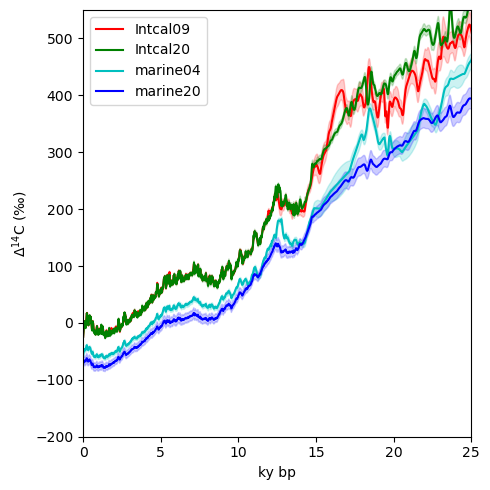

In [18]:
# sns.set()
fig , ax= plt.subplots(1,1,figsize=(5,5))
ax.plot(intcal09['CAL BP']*1/1000, intcal09['Delta 14C'], 'r-', label='Intcal09')
ax.fill_between(intcal09['CAL BP']/1000, intcal09['Delta 14C'] - intcal09['Sigma_Delta_14C'],
                 intcal09['Delta 14C'] + intcal09['Sigma_Delta_14C'], color='r', alpha=0.2)

ax.plot(intcal20['CAL BP']*1/1000, intcal20['Delta 14C'], 'g-', label='Intcal20')
ax.fill_between(intcal20['CAL BP']/1000, intcal20['Delta 14C'] - intcal20['Sigma_Delta_14C'],
                 intcal20['Delta 14C'] + intcal20['Sigma_Delta_14C'], color='g', alpha=0.2)

ax.plot(marine04['CAL BP']*1/1000, marine04['Delta 14C'], 'c-', label='marine04')
ax.fill_between(marine04['CAL BP']/1000, marine04['Delta 14C'] - marine04['Sigma_Delta_14C'],
                 marine04['Delta 14C'] + marine04['Sigma_Delta_14C'], color='c', alpha=0.2)

ax.plot(marine20['CAL BP']*1/1000, marine20['Delta 14C'], 'b-', label='marine20')
ax.fill_between(marine20['CAL BP']/1000, marine20['Delta 14C'] - marine20['Sigma_Delta_14C'],
                 marine20['Delta 14C'] + marine20['Sigma_Delta_14C'], color='b', alpha=0.2)

ax.set(**{'xlim':(0, 25), 'xlabel':'ky bp', 'ylim':(-200, 550), 'ylabel':tracer_label})
ax.legend()
plt.tight_layout()

Interesting to see how our understanding atmospheric radiocarbon has changed over the years. There is now considerably less volatility in both the marine and atmospheric records at the beginning of the deglaciation, and perhaps most notably, the spike at the beginning of the deglaciation in marine04 is no longer included.  

## Marchitto et al, 2007
Now let's load the data for Marchitto et al, 2007.  Pulling data directly from NCEI can be both convenient and also a little messy.  I've expedited the process by preparing a list of column names, which in turn makes it easier to load the tabular data. 

In [19]:
col_names = ['Sample', 'Taxa', 'Depth (Composite,m)','14Cage (kyrBP)','14Cage (err)',
 'Cal.Age (kyrBP)','Cal.Age (err)','D14C (permil)','d13C (permil)','Accession#','Son?','Reference']

marchitto2007 = pd.read_csv('https://www.ncei.noaa.gov/pub/data/paleo/contributions_by_author/marchitto2007b/marchitto2007b.txt',
           encoding="ISO-8859-1", names=col_names, skiprows=118, sep='\s\s+', nrows=50, engine='python')
marchitto2007['D14C (permil)']=marchitto2007['D14C (permil)'].apply(lambda x: int(x.replace('nm', '')))

Let's plot it along with the Intcal and Marine data.  I'm going to include the Marine04 record because that is the version that this paper used for reference.

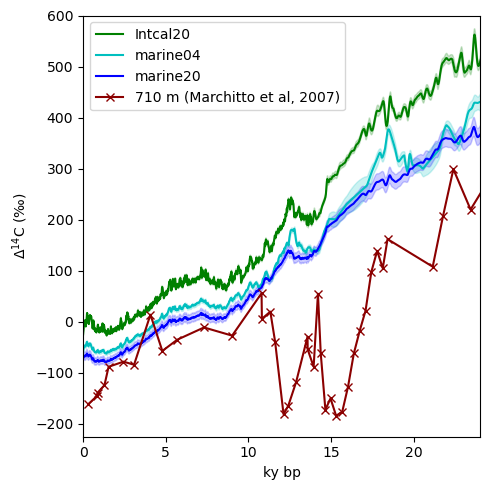

In [20]:
cal_bp2kya = 1/1000
fig , ax= plt.subplots(1,1,figsize=(5,5))
ax.plot(intcal20['CAL BP']*cal_bp2kya, intcal20['Delta 14C'], 'g-', label='Intcal20')
ax.fill_between(intcal20['CAL BP']*cal_bp2kya, intcal20['Delta 14C'] - intcal20['Sigma_Delta_14C'],
                 intcal20['Delta 14C'] + intcal20['Sigma_Delta_14C'], color='g', alpha=0.2)

ax.plot(marine04['CAL BP']*cal_bp2kya, marine04['Delta 14C'], 'c-', label='marine04')
ax.fill_between(marine04['CAL BP']*cal_bp2kya, marine04['Delta 14C'] - marine04['Sigma_Delta_14C'],
                 marine04['Delta 14C'] + marine04['Sigma_Delta_14C'], color='c', alpha=0.2)

ax.plot(marine20['CAL BP']*cal_bp2kya, marine20['Delta 14C'], 'b-', label='marine20')
ax.fill_between(marine20['CAL BP']*cal_bp2kya, marine20['Delta 14C'] - marine20['Sigma_Delta_14C'],
                 marine20['Delta 14C'] + marine20['Sigma_Delta_14C'], color='b', alpha=0.2)

ax.plot(marchitto2007['Cal.Age (kyrBP)'], marchitto2007['D14C (permil)'], 
        color='darkred', marker='x',label='710 m (Marchitto et al, 2007)' )
ax.set(**{'xlim':(0, 24), 'xlabel':'ky bp', 'ylim':(-225, 600), 'ylabel':tracer_label})
ax.legend()
plt.tight_layout()

## All together
Now we can query the C-iTrace output for the same (or as close as possible) location. In this case, I have the coordinates of the cores handy, but if I didn't, it would be a good application of just clicking the map somewhere slightly off the coast of the southern tip of Baja and going with that (at least for the moment). 

In [21]:
marchitto_site = {'lat': 23.4, 'lon': 249}


By a little trial and error, it turns out that `nlon=79` and `nlat=69` correspond to a point in the model grid very close to the Marchitto et al, 2007 site. 

In [22]:
prof = iso_ds.isel(nlon=79, nlat=69 )

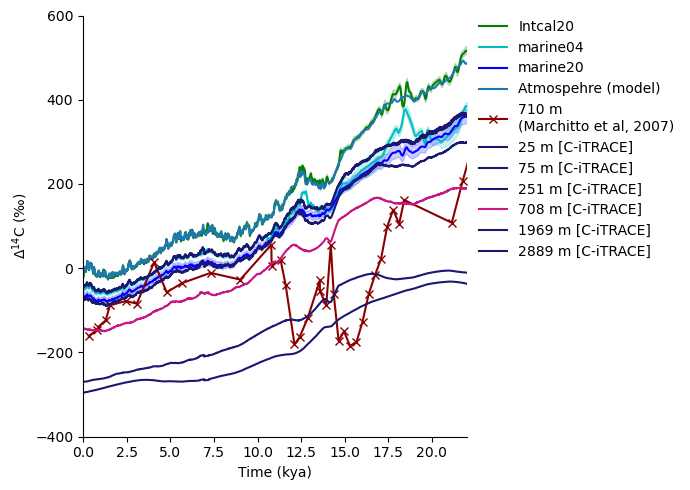

In [23]:
# fig, ax = plot_location_over_time(coords_d=marchitto_site)
fig , ax= plt.subplots(1,1,figsize=(7,5))

ax.plot(intcal20['CAL BP']*1/1000, intcal20['Delta 14C'], 'g-', label='Intcal20')
ax.fill_between(intcal20['CAL BP']/1000, intcal20['Delta 14C'] - intcal20['Sigma_Delta_14C'],
                 intcal20['Delta 14C'] + intcal20['Sigma_Delta_14C'], color='g', alpha=0.2)

ax.plot(marine04['CAL BP']*1/1000, marine04['Delta 14C'], 'c-', label='marine04')
ax.fill_between(marine04['CAL BP']/1000, marine04['Delta 14C'] - marine04['Sigma_Delta_14C'],
                 marine04['Delta 14C'] + marine04['Sigma_Delta_14C'], color='c', alpha=0.2)

ax.plot(marine20['CAL BP']*1/1000, marine20['Delta 14C'], 'b-', label='marine20')
ax.fill_between(marine20['CAL BP']/1000, marine20['Delta 14C'] - marine20['Sigma_Delta_14C'],
                 marine20['Delta 14C'] + marine20['Sigma_Delta_14C'], color='b', alpha=0.2)

ax.plot(-1*prof['ABIO_D14Catm'].time.data, prof['ABIO_D14Catm'].data, label='Atmospehre (model)')

ax.plot(marchitto2007['Cal.Age (kyrBP)'], marchitto2007['D14C (permil)'], 
        color='darkred', marker='x',label='710 m\n(Marchitto et al, 2007)' )

for idepth in [2, 7, 23,36,45,49]:
    ax.plot(-1*prof['ABIO_D14Cocn'].time.data, prof['ABIO_D14Cocn'].isel(z_t_m=idepth).data, 
            c ='midnightblue' if idepth !=36 else 'mediumvioletred', 
            label='{:.0f} m [C-iTRACE]'.format(prof['ABIO_D14Cocn'].isel(z_t_m=idepth).z_t_m.data))

ax.set(**{'xlim': [0, 22], 'ylabel': tracer_label, 'ylim':[-400,600], 'xlabel': 'Time (kya)'})
ax.legend(bbox_to_anchor=(1,1.02), loc='upper left', frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('C14_downcore_modelmarchitto.png', dpi='figure', format='png', metadata=None,
            bbox_inches='tight', #pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)

Interesting, so surface ocean trajectories from model output seem to agree reasonably well with Marine20, but the Marchitto et al, 2007 record seems to have its own (considerably more spirited?) story. The signal is certainly consistent with features of the atmospheric record, but none of the extreme behavior seems to be picked up in the C-iTrace run. 

## Resources and references


| _Citations_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|Gu, Sifan, Liu, Zhengyu, Jahn, Alexandra, Zanowski, Hannah. (2021). C-iTRACE. Version 1.0. UCAR/NCAR - DASH Repository. https://doi.org/10.5065/hanq-bn92. 
|Marchitto, T. M., Lehman, S. J., Ortiz, J. D., Flückiger, J., & van Geen, A. (2007). Marine radiocarbon evidence for the mechanism of deglacial atmospheric CO2 rise. Science, 316(5830), 1456-1459.